In [1]:
!pip install h5py

## Data

In [7]:
import h5py
import glob

path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
pace318_train = glob.glob(path + 'pace318_train_set/H5/*.h5')
pace318_test = glob.glob(path + 'pace318_test_set/H5/*.h5')

rowNum = 3

if pace318_train:
    with h5py.File(pace318_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 318\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
        print('\n\n')

else:
    print("File not found")

pace325_train = glob.glob(path + 'pace325_train_set/H5/*.h5')
pace325_test = glob.glob(path + 'pace325_test_set/H5/*.h5')

if pace325_train:
    with h5py.File(pace325_train[0], 'r') as file:
        print("Keys: %s" % list(file.keys()))
        first_geometry = file['geometry'][rowNum]
        first_input = file['inputs'][rowNum]
        first_output = file['outputs'][rowNum]

        print('Pace 325\n')
        print("first_geometry shape: ", first_geometry.shape, 
              "first_geometry: ", first_geometry, '\n')
        print("first_input shape: ", first_input.shape,
              "first_input: ", first_input, '\n')
        print("first_output shape: ", first_output.shape,
              "first_output: ", first_output, '\n')
else:
    print("File not found")

Keys: ['geometry', 'inputs', 'outputs']
Pace 318

first_geometry shape:  (3,) first_geometry:  [0.08914796 0.16880947 0.10318343] 

first_input shape:  (11,) first_input:  [0.08572294 0.61110255 0.85597203 0.82917943 0.00633835 0.73598566
 0.30098127 0.25647371 0.17699116 0.09897413 0.00674982] 

first_output shape:  (22,) first_output:  [0.02365114 0.15301892 0.12525921 0.09508325 0.06724529 0.04895108
 0.02794279 0.02531836 0.01383378 0.0101849  0.00736416 0.56117202
 0.64358048 0.63291136 0.6215687  0.60499423 0.60844916 0.58988128
 0.5607913  0.51324512 0.48958556 0.47816882] 




Keys: ['geometry', 'inputs', 'outputs']
Pace 325

first_geometry shape:  (3,) first_geometry:  [0.43138777 0.04664672 0.18537623] 

first_input shape:  (14,) first_input:  [0.3338711  0.58466833 0.69590435 0.95397432 0.52926811 0.89549399
 0.72597417 0.74137618 0.19366376 0.40013094 0.98825008 0.07634631
 0.9805122  0.84911726] 

first_output shape:  (22,) first_output:  [0.03969655 0.09654982 0.08385258 

## Training loop: pace318_train input vs output

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import h5py
import glob

In [8]:
# Custom Dataset class
class H5Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    
    def __len__(self):
        # Assuming all files have the same number of rows for simplicity
        with h5py.File(self.file_paths[0], 'r') as file:
            return file['geometry'].shape[0]
    
    def __getitem__(self, idx):
        # Load data from the first file for simplicity (can extend this for multiple files)
        with h5py.File(self.file_paths[0], 'r') as file:
            input_data = file['inputs'][idx]
            output_data = file['outputs'][idx]
        
        # Convert numpy arrays to PyTorch tensors
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        
        return input_tensor, output_tensor

# Path to the .h5 files
path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
pace318_train = glob.glob(path + 'pace318_train_set/H5/*.h5')
pace318_test = glob.glob(path + 'pace318_test_set/H5/*.h5')

# Create the dataset and dataloader
train_data = H5Dataset(pace318_train)
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# Example: Iterate over the dataloader
for batch_idx, (inputs, outputs) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs: {inputs.shape}")
    print(f"Outputs: {outputs.shape}")
    break  # Just showing one batch as an example


Batch 1
Inputs: torch.Size([32, 11])
Outputs: torch.Size([32, 22])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the regression model (a simple feedforward network)
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model and move it to the GPU (if available)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model = RegressionModel(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Create the dataset and dataloader (assuming H5Dataset is defined elsewhere)
train_data = H5Dataset(pace318_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = H5Dataset(pace318_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Training loop
num_epochs = 20  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [ ]:

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for inputs, targets in train_dataloader:
        # Move inputs and targets to the GPU (if available)
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'regression_model.pth')

print("Training complete and model saved.")


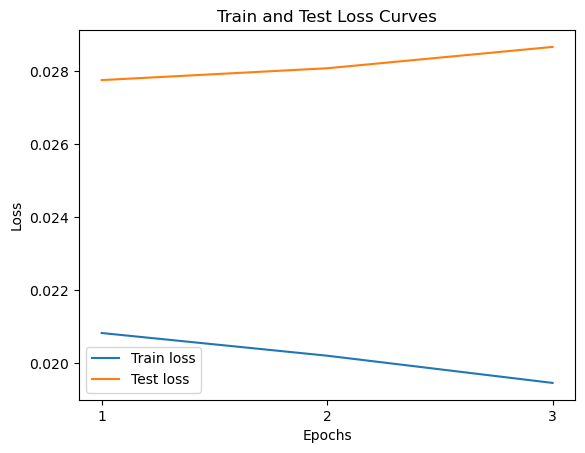

In [20]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Training with Both Geometry and Input

In [13]:
import torch
from torch.utils.data import Dataset
import h5py
import glob

# Custom Dataset class
class H5Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
    
    def __len__(self):
        # Assuming all files have the same number of rows for simplicity
        with h5py.File(self.file_paths[0], 'r') as file:
            return file['geometry'].shape[0]
    
    def __getitem__(self, idx):
        # Load data from the first file for simplicity (can extend this for multiple files)
        with h5py.File(self.file_paths[0], 'r') as file:
            geometry_data = file['geometry'][idx]   # Shape: (3,)
            input_data = file['inputs'][idx]        # Shape: (11,)
            output_data = file['outputs'][idx]      # Shape: (22,)
        
        # Convert numpy arrays to PyTorch tensors
        geometry_tensor = torch.tensor(geometry_data, dtype=torch.float32)
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        output_tensor = torch.tensor(output_data, dtype=torch.float32)
        
        return geometry_tensor, input_tensor, output_tensor

# Path to the .h5 files
path = '/home/sunzid/Research/23-24_Automatic-Control-Lab/Projects/24_Aerosol/data/'
pace318_train = glob.glob(path + 'pace318_train_set/H5/*.h5')
pace318_test = glob.glob(path + 'pace318_test_set/H5/*.h5')

# Create the dataset and dataloader
train_data = H5Dataset(pace318_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

# Example: Iterate over the dataloader
for batch_idx, (geometry, inputs, outputs) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Geometry: {geometry.shape}")  # Expected shape: (batch_size, 3)
    print(f"Inputs: {inputs.shape}")      # Expected shape: (batch_size, 11)
    print(f"Outputs: {outputs.shape}")    # Expected shape: (batch_size, 22)
    break  # Just showing one batch as an example


Batch 1
Geometry: torch.Size([32, 3])
Inputs: torch.Size([32, 11])
Outputs: torch.Size([32, 22])


In [ ]:
# Create the dataset and dataloader (assuming H5Dataset is defined elsewhere)
train_data = H5Dataset(pace318_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = H5Dataset(pace318_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if a GPU is available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the combined regression model
class CombinedRegressionModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(geometry_size + input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
model = CombinedRegressionModel(geometry_size, input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 2  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [15]:

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/2], Train Loss: 0.0013, Test Loss: 0.0080
Epoch [2/2], Train Loss: 0.0003, Test Loss: 0.0080
Training complete and model saved.


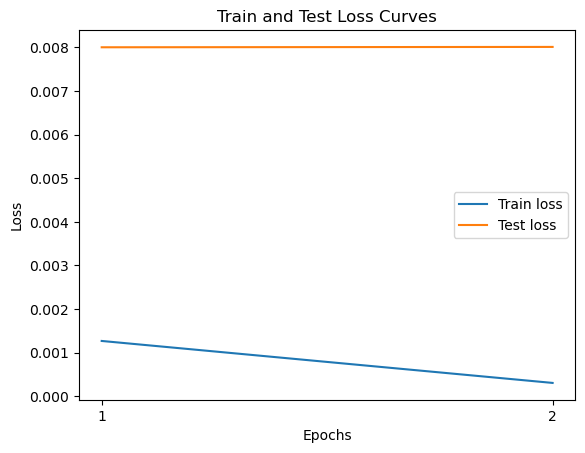

In [16]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Model with Conv layers

In [17]:
import torch
import torch.nn as nn

class CombinedRegressionModelWithConv(nn.Module):
    def __init__(self, geometry_size, input_size, output_size):
        super(CombinedRegressionModelWithConv, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers after flattening
        self.fc1 = nn.Linear((geometry_size + input_size) * 16, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_size)
    
    def forward(self, geometry, input_data):
        # Concatenate geometry and input tensors along the last dimension
        x = torch.cat((geometry, input_data), dim=-1)
        
        # Reshape to add a channel dimension for 1D convolution: (batch_size, 1, total_size)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, geometry_size + input_size)
        
        # Apply convolutional layers with ReLU activation and pooling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [20]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11  # Input shape (11 features)
output_size = 22  # Output shape (22 features)
pace318_conv_model = CombinedRegressionModelWithConv(geometry_size, input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(pace318_conv_model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 1  # Number of training epochs

epoch_count = []
train_loss_values = []
test_loss_values = []


In [21]:

for epoch in range(num_epochs):
    pace318_conv_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = pace318_conv_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    pace318_conv_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = pace318_conv_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0015, Test Loss: 0.0075
Training complete and model saved.


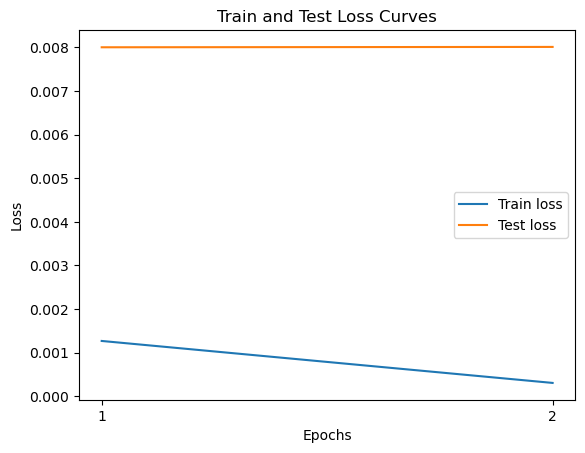

In [ ]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Transformer model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class TransformerModel(nn.Module):
    def __init__(self, geometry_size, input_size, output_size, n_heads=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        
        self.concat_dim = geometry_size + input_size
        
        # Ensure concatenated dimension is divisible by n_heads
        assert self.concat_dim % n_heads == 0, "Concat dimension must be divisible by num_heads"
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.concat_dim, nhead=n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(self.concat_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, geometry, input_data):
        x = torch.cat((geometry, input_data), dim=-1).unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x).squeeze(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [27]:

# Instantiate the model and move it to the GPU (if available)
geometry_size = 3  # Geometry shape (3 features)
input_size = 11    # Input shape (11 features)
output_size = 22   # Output shape (22 features)
transformer_model = TransformerModel(geometry_size, input_size, output_size, n_heads=2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)  # Adam optimizer


epoch_count = []
train_loss_values = []
test_loss_values = []


/home/sunzid/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [28]:

for epoch in range(num_epochs):
    transformer_model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for geometry, inputs, targets in train_dataloader:
        # Move inputs, geometry, and targets to the GPU (if available)
        geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        outputs = transformer_model(geometry, inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the test set
    transformer_model.eval()  # Set model to evaluation mode
    test_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for geometry, inputs, targets in test_dataloader:
            geometry, inputs, targets = geometry.to(device), inputs.to(device), targets.to(device)
            outputs = transformer_model(geometry, inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    # Calculate average test loss for this epoch
    avg_test_loss = test_loss / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'combined_regression_model.pth')

print("Training complete and model saved.")


Epoch [1/1], Train Loss: 0.0036, Test Loss: 0.0115
Training complete and model saved.


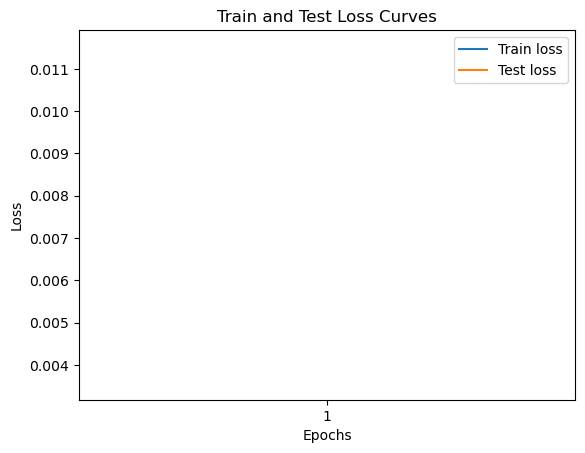

In [29]:
import matplotlib.pyplot as plt

# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=epoch_count)

plt.show()


## Testing performance

### Show performance graphically

1. Line Plot for Each Feature
Plotting each of the 22 features with separate line plots lets you clearly compare the predicted and actual values for each feature across samples.

In [30]:
import matplotlib.pyplot as plt

def plot_output_comparison(y_true, y_pred, sample_idx=0):
    plt.figure(figsize=(15, 10))
    for i in range(22):
        plt.subplot(5, 5, i + 1)
        plt.plot(y_true[:, i], label='Actual', color='blue')
        plt.plot(y_pred[:, i], label='Predicted', color='red', linestyle='--')
        plt.title(f'Output {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()


2. Scatter Plot of Actual vs. Predicted for Each Feature
A scatter plot for each output feature can show the relationship between actual and predicted values. Ideally, points should fall along the 45-degree line if predictions are accurate.

In [ ]:
import numpy as np

def scatter_plot_comparison(y_true, y_pred):
    plt.figure(figsize=(15, 10))
    for i in range(22):
        plt.subplot(5, 5, i + 1)
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f'Output {i+1}')
    plt.tight_layout()
    plt.show()


3. Bar Plot of Error for Each Output Feature
Calculate the mean absolute error for each output feature across all samples, then plot as a bar chart to compare errors per feature.

In [ ]:
import numpy as np

def plot_error_bar(y_true, y_pred):
    errors = np.abs(y_true - y_pred).mean(axis=0)  # Mean absolute error for each output feature
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 23), errors, color='orange')
    plt.xlabel('Output Feature')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error per Output Feature')
    plt.show()


4. Overlayed Line Plot of Sample Predictions
Plot predictions and actual values for all features of a single sample, with each feature represented by a different line in the same plot.

In [ ]:
def plot_single_sample_comparison(y_true, y_pred, sample_idx=0):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[sample_idx], label="Actual", marker='o', color='blue')
    plt.plot(y_pred[sample_idx], label="Predicted", marker='x', color='red')
    plt.xlabel('Output Feature')
    plt.ylabel('Value')
    plt.title(f'Comparison for Sample {sample_idx + 1}')
    plt.legend()
    plt.show()


5. Heatmap of Prediction Errors
Display a heatmap showing errors across multiple samples for all features, with each row representing a sample and each column representing an output feature.

In [ ]:
import seaborn as sns

def plot_error_heatmap(y_true, y_pred):
    errors = np.abs(y_true - y_pred)  # Calculate absolute error
    plt.figure(figsize=(12, 8))
    sns.heatmap(errors, cmap="coolwarm", cbar=True)
    plt.xlabel("Output Feature")
    plt.ylabel("Sample")
    plt.title("Absolute Errors for Each Sample and Output Feature")
    plt.show()


### Performance tests


1. Accuracy
Definition: The ratio of correct predictions to the total number of predictions.
Use Case: Suitable when classes are balanced.

In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")


2. Confusion Matrix
Definition: A table that shows the counts of true positives, true negatives, false positives, and false negatives for each class.
Use Case: Helpful for visualizing performance across classes and identifying specific classes that the model struggles with.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


3. Precision, Recall, and F1 Score
Precision: Measures how many positive predictions were actually correct (useful for assessing false positives).
Recall: Measures how many true positives were correctly identified (useful for assessing false negatives).
F1 Score: The harmonic mean of precision and recall, giving a balanced metric for imbalanced classes.
Use Case: Particularly helpful when class distribution is skewed, or for evaluating models in situations where false positives or false negatives have significant consequences.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_classification_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


4. ROC Curve and AUC (Area Under the Curve)
ROC Curve: Plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.
AUC: Measures the area under the ROC curve, with a higher AUC indicating better model performance across thresholds.
Use Case: Useful for binary and multi-class classification, especially in situations with class imbalance.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label="ROC Curve (AUC = %.2f)" % roc_auc_score(y_true, y_proba))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


5. Precision-Recall Curve and Average Precision (AP)
Precision-Recall Curve: Plots precision against recall at various probability thresholds.
Average Precision (AP): Summarizes the precision-recall curve as a single score, useful in the context of imbalanced datasets.
Use Case: Particularly insightful for datasets with a high class imbalance.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, precision, label="Precision-Recall Curve (AP = %.2f)" % ap)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()


6. Log Loss (Cross-Entropy Loss)
Definition: Measures the uncertainty of predictions, penalizing both overconfident wrong predictions and underconfident right predictions.
Use Case: Useful for models that output probabilities rather than hard labels.

In [ ]:
from sklearn.metrics import log_loss

def compute_log_loss(y_true, y_proba):
    loss = log_loss(y_true, y_proba)
    print(f"Log Loss: {loss:.4f}")


7. Classification Report
Definition: Summarizes precision, recall, F1-score, and support for each class.
Use Case: A quick way to evaluate the model’s performance across classes.


In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print(report)
